# Warm up 14 - Vehicle Stock in China

TEP4290, Spring 2024

## Preparation: Packages and data imports

Start by importing the necessary packages:

In [4]:
# Write all the necessary imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dynamic_stock_model import DynamicStockModel

Then import the data into a Dataframe using the pandas read_excel function (check the documentation to find out which arguments to use) and clean it.

In [5]:
#Working directory ?
working_directory = os.getcwd()
print(working_directory)

c:\Users\jujug\Documents\Ecole\4. NTNU\MFA2\TEP4290\TEP4290-juliette\Warm_up_14_chinese_vehicle_fleet


In [6]:
# Extracting data from the source file into a panda Dataframe
file = "Warm_up_14_data.xls"
# This file should be placed in the same directory as this notebook (on the JupyterHub server)

# We read the data and store it in a Dataframe called "data", using the read_excel() panda function
data = pd.read_excel(file, sheet_name="CarStockData",usecols="D:P", header =1,)

# Drop the first two rows
data = data.drop(index=[0,1])
data = data.reset_index(drop=True)

# This is just to replace all the void values in "data" by 0, which makes things easier
data.fillna(0, inplace=True)


C:\Users\jujug\AppData\Local\Temp\ipykernel_22428\3479403728.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0, inplace=True)


We create two Dataframes from data:
 - historic_data with values up to 2008
 - future_data with values for 2009 and after


In [7]:
historic_data = data[data.Time < 2009]
future_data = data[data.Time >= 2009]

## Inflow-driven model

Calculate outflows, stock change and stock for historic data, using an inflow-driven model:

In [ ]:
# Parameters of the lifetime distribution
mean_lifetime = 15
stddev_lifetime = 5
n_years = len(historic_data["Time"])


lt_mean = np.full(n_years, mean_lifetime)
lt_std = np.full(n_years, stddev_lifetime)

# Reset the index 
historic_data = historic_data.reset_index(drop=True)

# Maintenant crée ton modèle
inflow_driven_model = DynamicStockModel(
    t = historic_data["Time"].values,
    i = historic_data["Inflow"].values, 
    lt = {'Type': 'Normal', 'Mean': lt_mean, 'StdDev': lt_std}
)
# Create a new attribute in the class dynamic stock model
inflow_driven_model = DynamicStockModel(
    t = historic_data["Time"], 
    i = historic_data["Inflow"], 
    lt = {'Type': 'Normal', 'Mean': lt_mean, 'StdDev': lt_std })

# Compute the entire model
Stock_by_cohort, ExitFlag = inflow_driven_model.compute_s_c_inflow_driven()



In [9]:
# Add the outflow in the historic_data

inflow_driven_model.o_c = None
Outflow_by_cohort, ExitFlag = inflow_driven_model.compute_o_c_from_s_c()
outflow_total = Outflow_by_cohort.sum(axis=1)
historic_data["Outflow"] = outflow_total

# Compute the stock change in historic data
historic_data["Stock Change"] = historic_data["Inflow"] - historic_data["Outflow"]

#Compute stock in historic data
historic_data["Stock"] = historic_data["Stock Change"].cumsum()


In [10]:
# merge historic data and data

data["Outflow"] = historic_data["Outflow"]
data["Stock Change"] = historic_data["Stock Change"]
data["Stock"] = historic_data["Stock"]

## Stock-driven model

Calculate stock change, outflows and inflows for future data, using a stock-driven model.
You need to run the stock-driven model for all years, combining historic stock data from the inflow-driven model, and future stock data from population and car ownership projections.

In [11]:
#Compute the stock between 2009 and 2050
mask = data['Time'] >= 2009
data.loc[mask, "Stock"] = data.loc[mask, "cars per 1000 people"] * data.loc[mask, "Population"]

In [12]:
# Parameters of the lifetime distribution for the entire data
n_years = len(data["Time"])
lt_mean = np.full(n_years, mean_lifetime)
lt_std = np.full(n_years, stddev_lifetime)

# Create the stock driven model
stock_driven_model = DynamicStockModel(t = data["Time"], 
                                       s = data["Stock"], 
                                       lt = {'Type': 'Normal', 'Mean': lt_mean, 'StdDev': lt_std })

CheckStr, ExitFlag = stock_driven_model.dimension_check()
print(CheckStr)


<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 101 years.<br>Inflow is not present.<br>Total stock is present with 101 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15].<br>


In [13]:
# Compute the entire model

S_C, O_C, I, ExitFlag = stock_driven_model.compute_stock_driven_model()
O, ExitFlag   = stock_driven_model.compute_outflow_total()
DS, ExitFlag  = stock_driven_model.compute_stock_change()
Bal, ExitFlag = stock_driven_model.check_stock_balance()
print(Bal)
     

[ 0.00000000e+00  0.00000000e+00  4.54747351e-13  0.00000000e+00
  4.54747351e-13  0.00000000e+00  9.09494702e-13 -1.36424205e-12
 -9.09494702e-13  9.09494702e-13 -3.18323146e-12 -4.54747351e-13
  3.63797881e-12  1.81898940e-12  0.00000000e+00 -4.54747351e-12
  2.72848411e-12  4.54747351e-12 -6.36646291e-12  4.54747351e-12
 -2.72848411e-12  1.81898940e-12 -7.27595761e-12  1.45519152e-11
 -1.09139364e-11 -7.27595761e-12  0.00000000e+00  3.63797881e-12
  2.91038305e-11 -3.63797881e-11  1.45519152e-11 -4.36557457e-11
 -7.27595761e-12  1.23691279e-10 -4.36557457e-11  0.00000000e+00
 -8.73114914e-11  5.82076609e-11 -8.73114914e-11  5.82076609e-11
  5.82076609e-11  1.16415322e-10 -1.16415322e-10 -2.32830644e-10
  5.82076609e-10 -1.16415322e-10  0.00000000e+00  3.49245965e-10
 -3.49245965e-10 -1.16415322e-10  0.00000000e+00 -4.65661287e-10
  6.98491931e-10 -1.39698386e-09  9.31322575e-10  1.86264515e-09
 -4.65661287e-09  1.86264515e-09  1.86264515e-09 -5.58793545e-09
  6.51925802e-09 -1.86264

In [14]:
# extract the outflow 
stock_driven_model.o_c = None 
Outflow_by_cohort, ExitFlag_O = stock_driven_model.compute_o_c_from_s_c()
outflow_total = Outflow_by_cohort.sum(axis=1)

# add the outflow and inflow in future data
data["Outflow"] = outflow_total
data["Inflow"] = I

# compute stock and stock change in future data
data["Stock Change"] = data["Inflow"] - data["Outflow"]
data["Stock"] = S_C.sum(axis=1)

In [15]:
# Save the data to a new excel file
data.to_excel("Warm_up_14_new_data.xlsx", index=False)

## Final calculations

Perform the calculations for distance driven, fuel consumption and CO2 emissions

In [31]:
#Compute the Stock_TC

#create à 101*101 matrix
n_total = len(data["Time"])
n_hist = len(historic_data)
stock_tc = np.zeros((n_total, n_total))

# Add the historic data
stock_tc[:n_hist,:n_hist] = inflow_driven_model.s_c

# Add the future data
stock_tc[n_hist:, :] = S_C[n_hist:, :]

In [ ]:
# car per 1000 people = data["Stock"] / data["Population"] * 1000
data["cars per 1000 people"] = data["Stock"] / data["Population"] * 1000

# Total direct CO2 emissions (billion/km year) = data["Stock"] * data["Kilometrage per vehicle"] / 1e9
data["Total direct CO2 emissions"] = data["Stock"] * data["Kilometrage per vehicle"] / 1e9

# total fuel consumption (million liters/year) = einsum(tc,c)
data["Total gasoline consumend"] = np.einsum('tc,c->t', stock_tc, data["Fuel efficiency"].values / 100) * data["Kilometrage per vehicle"].values / 1e6

# total carbon emissions (Mt/year) = data["Total fuel consumption"] * data["Carbon Intensity"] / 1e6
data["Total direct CO2 emissions"] = (data["Total gasoline consumend"] * data["Carbon intensity"].values) / 1000
                                                     
                                                                                                        

In [35]:
# Save the data to a new excel file
data.to_excel("Warm_up_14_new_data.xlsx", index=False)

## Plot the results

Plot the results of the model for inflows and outflows, stock change, stock, total distance driven, total fuel consumption, and total CO2 emissions

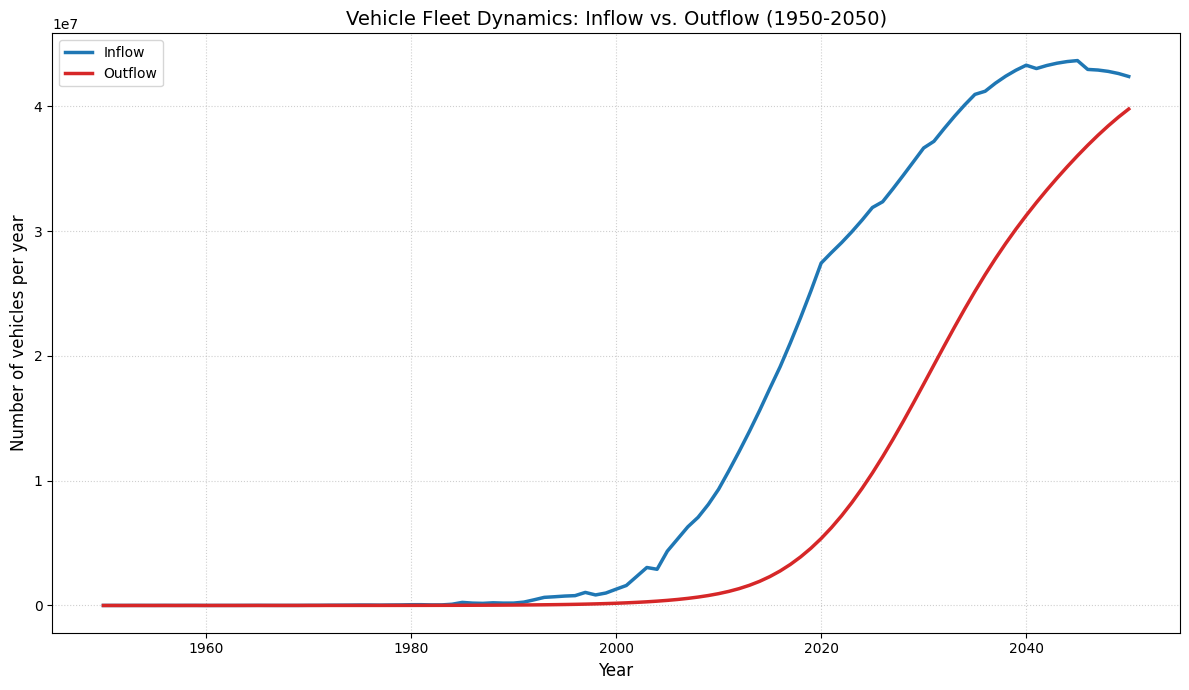

In [61]:
# Inflows and outflows
plt.figure(figsize=(12, 7))

# Plot Inflow 
plt.plot(data["Time"], data["Inflow"], 
         color="#1f77b4", linewidth=2.5, label="Inflow")

# Plot Outflow 
plt.plot(data["Time"], data["Outflow"], 
         color="#d62728", linewidth=2.5, label="Outflow")



# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Inflow vs. Outflow (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of vehicles per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_Inflow_Outflow.png", dpi=300)
plt.show()



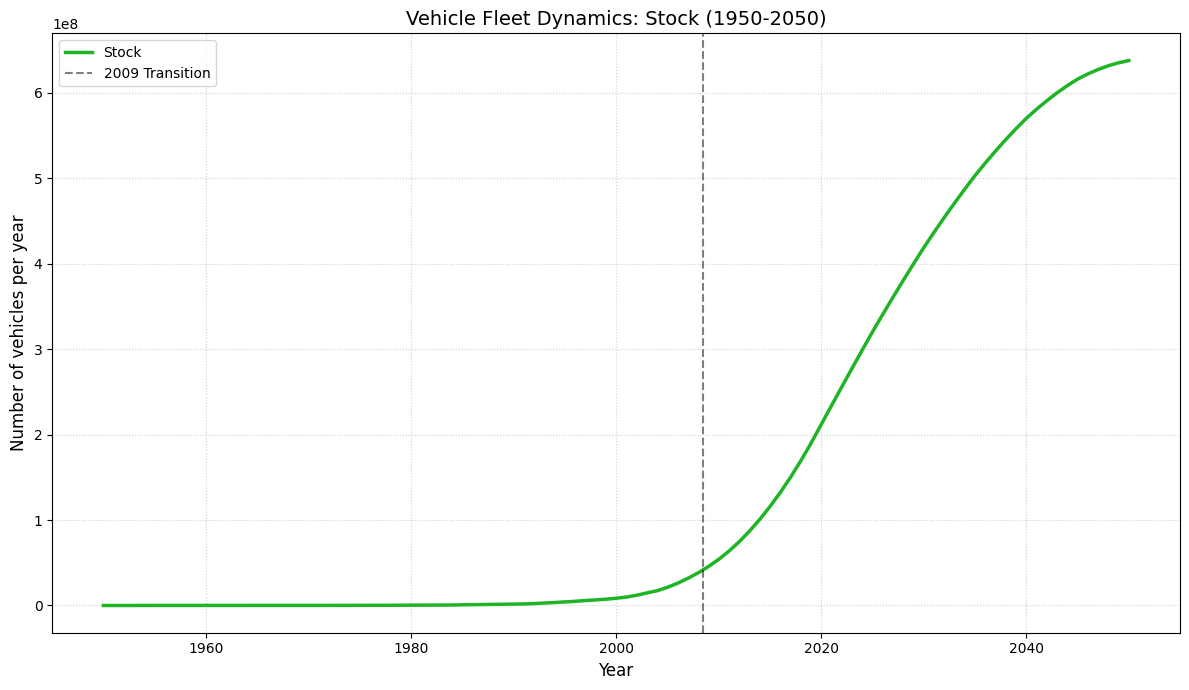

In [59]:
# Srock
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Stock"], 
         color="#1fb426", linewidth=2.5, label="Stock")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Stock (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of vehicles per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_stock.png", dpi=300)
plt.show()



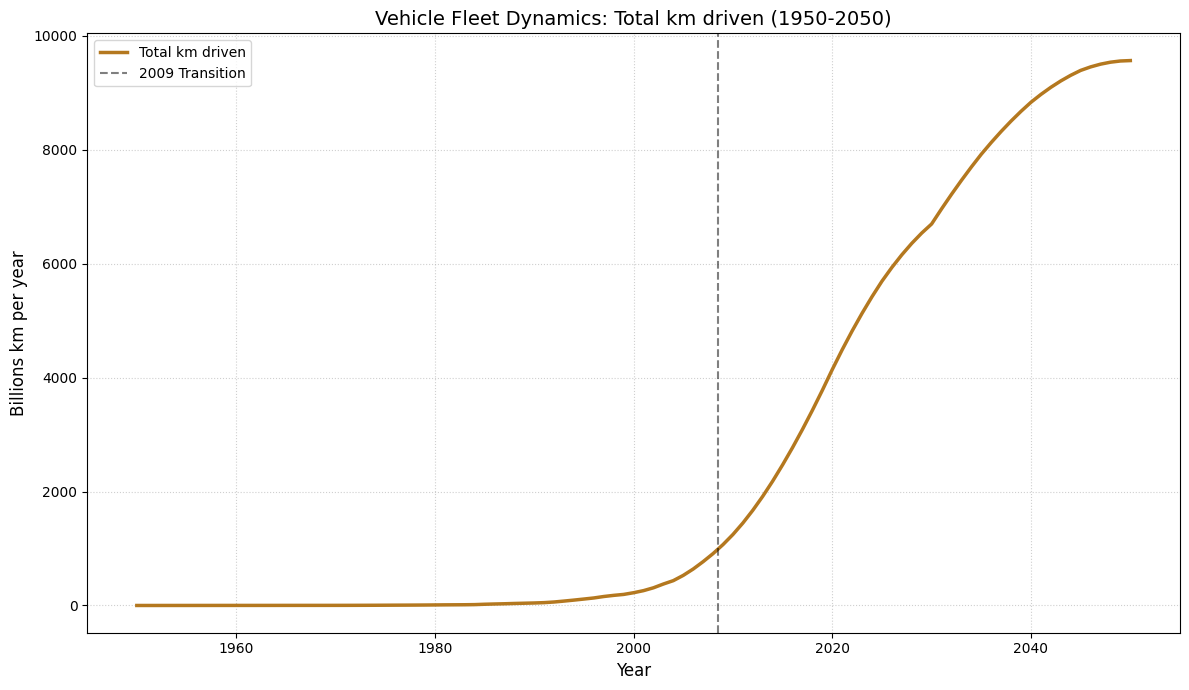

In [56]:
# Total km driven
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Total km driven"], 
         color="#b4781f", linewidth=2.5, label="Total km driven")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Total km driven (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Billions km per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_km_driven.png", dpi=300)
plt.show()



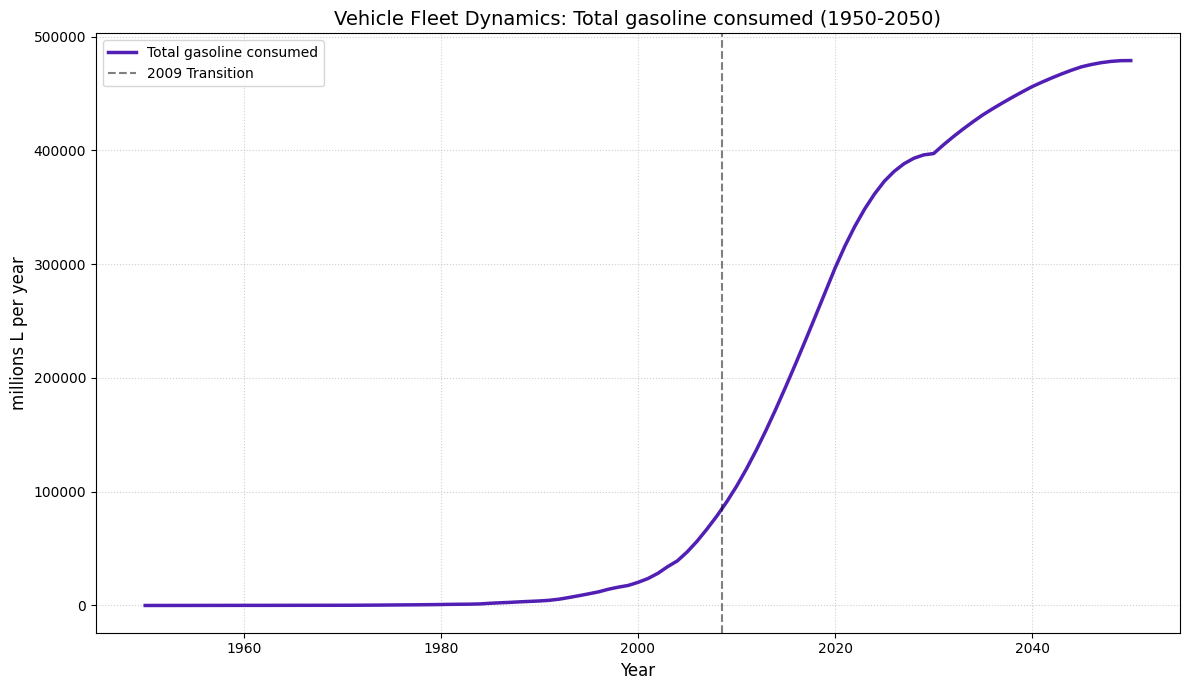

In [57]:
# Total gasoline consumed
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Total gasoline consumend"], 
         color="#511fb4", linewidth=2.5, label="Total gasoline consumed")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Total gasoline consumed (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("millions L per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_fuel.png", dpi=300)
plt.show()



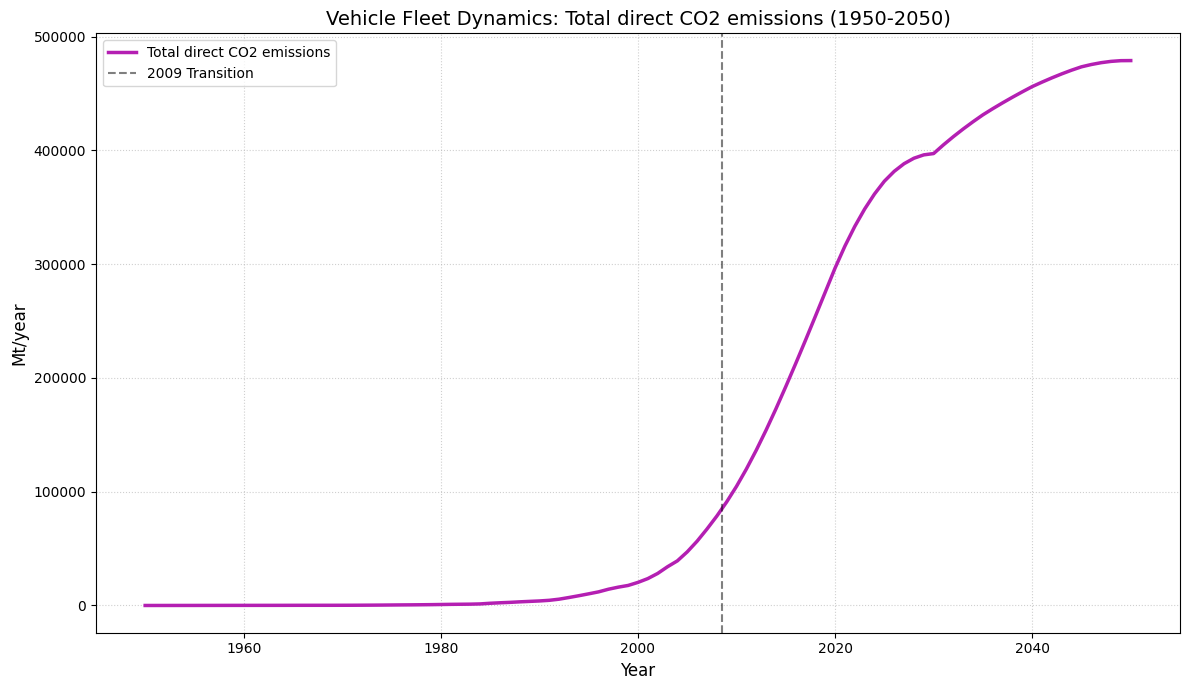

In [58]:
# Total CO2 emissions
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Total gasoline consumend"], 
         color="#b41fb2", linewidth=2.5, label="Total direct CO2 emissions")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Total direct CO2 emissions (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mt/year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_co2.png", dpi=300)
plt.show()



## Exports the results

Export the results to a new Excel file - you can then in the end before submission copy the stock over to the existing data if you prefer to, but it is not required of you

In [63]:
# Save the data to a new excel file
data.to_excel("Warm_up_14_new_data.xlsx", index=False)
pd.DataFrame(stock_tc).to_excel("Warm_up_14_stock_tc.xlsx", index=False)

## Interpretation